In [174]:
from pathlib import Path
from math import sqrt

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load reference data

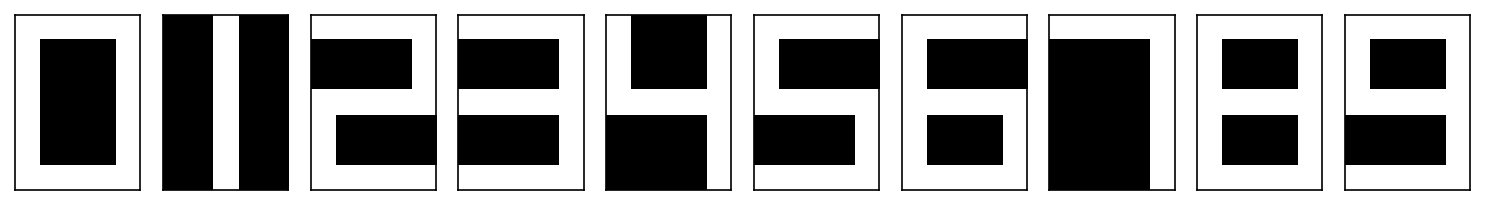

In [175]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

data_path = Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

### Generate dataset

In [275]:
cells_columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns + ['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, data_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = data_mtrx[i] + np.random.uniform(0, 0.5, img_size)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [276]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns]).astype(np.float64)
y_test = np.array(df.iloc[idx_test][label_columns]).astype(np.float64)

x_train = np.array(df.iloc[idx_train][features_columns]).astype(np.float64)
y_train = np.array(df.iloc[idx_train][label_columns]).astype(np.float64)

### Define functions

In [211]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [212]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, W: np.ndarray) -> np.ndarray:
    dW = np.zeros(W.shape)

    h = np.zeros((W.shape[0], W.shape[2]))

    for i in range(x_batch.shape[0]):
        for j in range(W.shape[0]):
            h[j] = W[j].T @ y_batch[i]

        z = np.sum(h, axis=0)

        dLdz = 2 * (z - x_batch[i])
        dLdw = np.outer(y_batch[i], dLdz)

        for j in range(W.shape[0]):
            dW[j] += dLdw

    return dW


class Perceptron:
    def __init__(self, nIn: int, nOut: int, nL: int) -> None:
        self.nIn: int = nIn
        self.nOut: int = nOut
        self.nL: int = nL

        self.W: np.ndarray = np.random.uniform(-1, 1, (nL, nOut, nIn))

    def predict(self, x: np.ndarray) -> np.ndarray:
        w = np.sum(self.W, axis=0)
        return mcosim(w, x)

    def loss(self, x_batch: np.ndarray, y_batch: np.ndarray) -> float:
        y_pred_batch = np.array([self.predict(x) for x in x_batch])
        h = np.sum(y_batch * y_pred_batch, axis=1)
        return 1 - np.mean(h)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW  = grads(x_train[batch_idxs], y_train[batch_idxs], self.W)

                self.W -= lr * dW

### Create and train model

In [277]:
nIn = 35
nOut = 10
nL = 5

learning_rate = 1e-3
batch_size = 16
max_epoch = 100

model = Perceptron(nIn, nOut, nL)

print('trained loss: ', model.loss(x_test, y_test).round(5))

model.train(x_train, y_train, learning_rate, batch_size, max_epoch)

print('trained loss: ', model.loss(x_test, y_test).round(5))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

trained loss:  0.9384
trained loss:  0.02059
test set accuracy: 100.0%


### Test model on big number of noised samples

In [278]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10

    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    
    n_true_pos += 1 if j == np.argmax(ypred) else 0

accuracy = round(n_true_pos / n_samples * 100, 2)
print(f"accuracy: {accuracy}% ({n_true_pos} of {n_samples})")

accuracy: 98.47% (9847 of 10000)


### Visualize model predictions

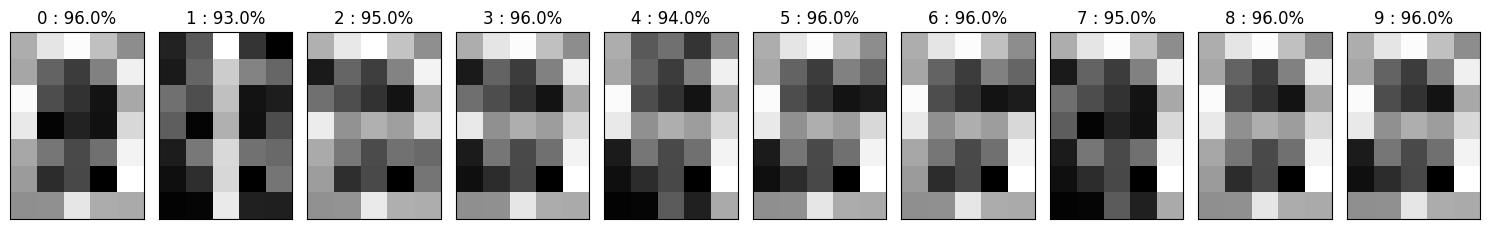

In [279]:
noise_size = 1.0
x_noised = data_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])

    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [280]:
w = np.sum(model.W, axis=0)

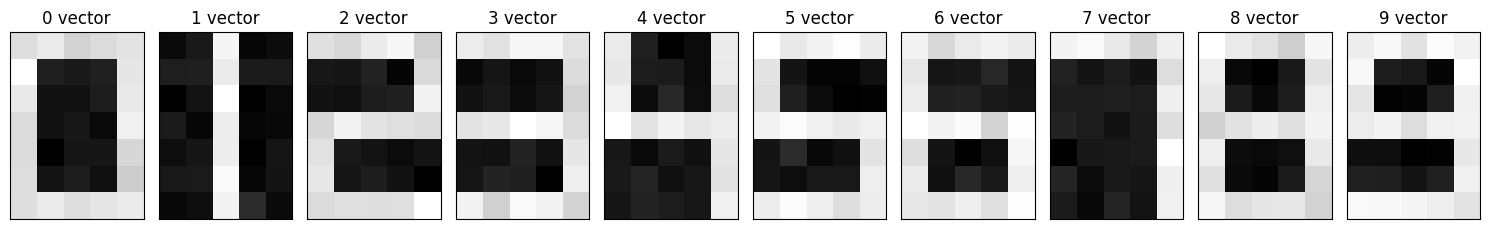

In [285]:
fig, axes = plt.subplots(nrows=1, ncols=model.nOut)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

for i in range(model.nOut):
    img = axes[i].imshow(w[i].reshape(img_shape), cmap='binary_r')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'{i} vector')

plt.tight_layout()
plt.show()

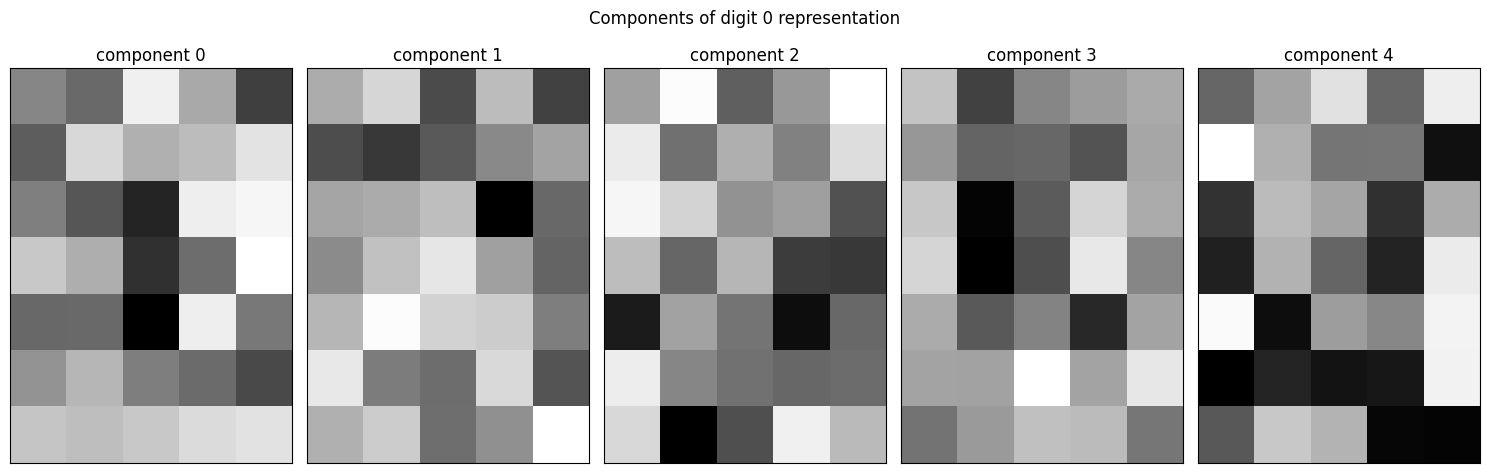

In [284]:
fig, axes = plt.subplots(nrows=1, ncols=model.nL)
fig.set_figwidth(15)
fig.set_figheight(5)
fig.set_dpi(100)

idx = 0

for i in range(model.nL):
    img = axes[i].imshow(model.W[i][idx].reshape(img_shape), cmap='binary_r')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title(f'component {i}')

fig.suptitle(f'Components of digit {idx} representation')

plt.tight_layout()
plt.show()